In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# turning CoW on so that original datasets remain
# unchanged when their copies are being altered
pd.options.mode.copy_on_write = True

In [ ]:
# establishing the target varialbe
target_var = 'sales'

In [ ]:
file_path = 'badminton.csv'
df = pd.read_csv(file_path)

# changing the names of the header columns
df.rename(columns={'startDate': 'date', 'sellerMetric.value': 'sales', 'platformMetric.value': 'total_sales'},
          inplace=True)

# changing the elements of the date column to datetime
df.loc[:, 'date'] = pd.to_datetime(df.loc[:, 'date'])

In [ ]:
df.head()

,date,sales,total_sales
0,2022-07-30 00:00:00,13232.0,188721.0
1,2022-07-31 00:00:00,6928.0,208330.0
2,2022-08-01 00:00:00,10322.0,239983.0
3,2022-08-02 00:00:00,8625.0,194862.0
4,2022-08-03 00:00:00,8496.0,286282.0


# Verifying the validity of the dataset given

In [ ]:
def verify(data_frame):
    n = data_frame.shape[0]  # the number of rows
    is_valid = True
    for i in range(1, n):
        prev = pd.Timestamp(data_frame.loc[i - 1, 'date'])
        curr = pd.Timestamp(data_frame.loc[i, 'date'])

        # if the previous date recorded in the dataframe was more than a day before
        #  the current date, then there's a gap
        if (curr - prev) > pd.Timedelta(days=1):
            is_valid = False

        # if the previous date recorded is the same as the current date, it means
        # that there are repetitions in the dataframe
        if curr == prev:
            is_valid = False

    return is_valid

In [ ]:
verify(df)

True

# Processing outliers within sales

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from scipy.optimize import minimize

## Optimizing share coefficients

In [ ]:
# the initial share of preprocessed sales column relative to total_sales column
initial_share = df['sales'].mean() / df['total_sales'].mean()

In [ ]:
# adding a column that identifies outliers withn sales column
df['is_outlier'] = df['sales'] < (initial_share * df['total_sales'] * 2 / 3)

In [ ]:
df_good = df.query('is_outlier == False')

In [ ]:
# here we're trying to estimate the pseudooptimal share, which is the
# most optimal share within those we have, and yet not necessarily is
# the most optimal share overall;
# it'll be used as the initial guess for finding the optimal share

shares = df_good['sales'] / df_good['total_sales']
min_error, pseudooptimal_share = float('inf'), None
for share in shares:
    if min_error > mse(df_good['sales'], df_good['total_sales'] * share):
        min_error = mse(df_good['sales'], df_good['total_sales'] * share)
        pseudooptimal_share = share

In [ ]:
optimal_share = minimize(lambda x: mse(df_good['sales'], df_good['total_sales'] * x),
                        x0=pseudooptimal_share, method="BFGS").x[0]

## Adding changes

In [ ]:
df['sales'] = pd.Series(
    [[df.loc[i, 'sales'], df.loc[i, 'total_sales'] * optimal_share * 1.25][int(df.loc[i, 'is_outlier'])]
     for i in range(df.shape[0])]
)

In [ ]:
df.drop(columns=['is_outlier'], inplace=True)

# Data visualisation

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def visualize(*args, title=None, method=plt.plot):
    plt.figure(figsize=(10, 5))
    for (xData, yData, name) in args:
        method(xData, yData, label=name)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

## By day

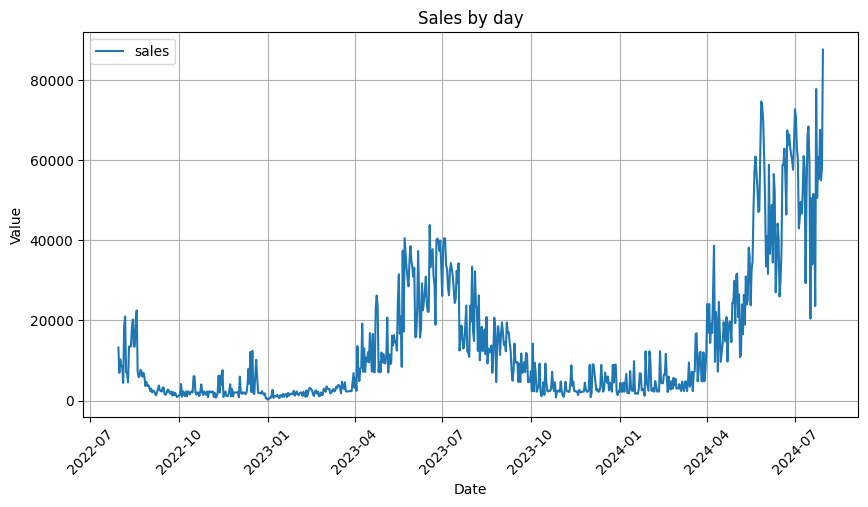

In [ ]:
visualize((df['date'], df[target_var], target_var),
          title='Sales by day', method=plt.plot)

## By week

In [ ]:
weekly_sum = df.groupby(pd.Grouper(key='date', freq='1W')).sum().reset_index()

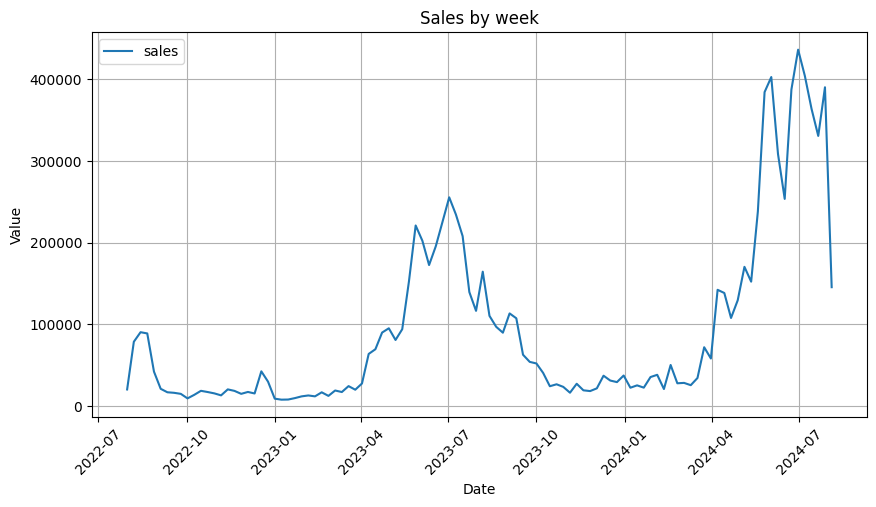

In [ ]:
visualize((weekly_sum['date'], weekly_sum[target_var], target_var),
          title='Sales by week', method=plt.plot)

## By month

In [ ]:
monthly_sum = df.groupby(pd.Grouper(key='date', freq='ME')).sum().reset_index()

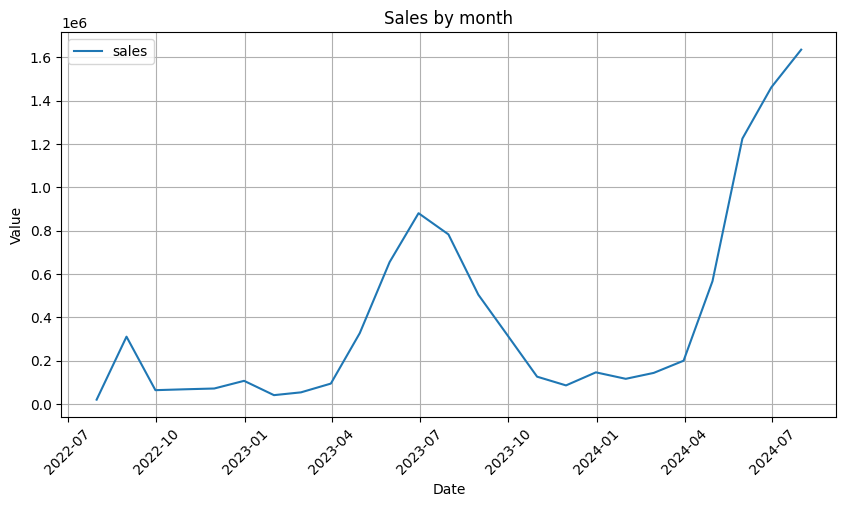

In [ ]:
visualize((monthly_sum['date'], monthly_sum[target_var], target_var),
          title='Sales by month', method=plt.plot)

## By year

In [ ]:
annual_sum = df.groupby(pd.Grouper(key='date', freq='YE')).sum().reset_index()

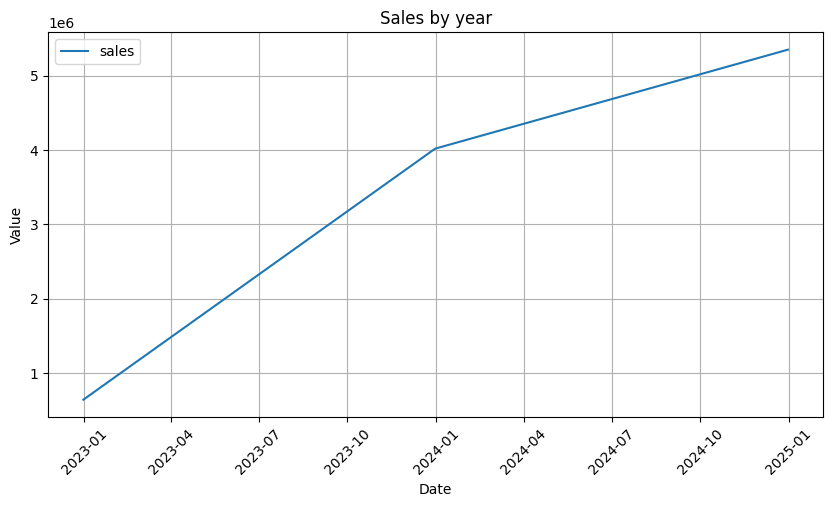

In [ ]:
visualize((annual_sum['date'], annual_sum[target_var], target_var),
          title='Sales by year', method=plt.plot)

# Forecast

In [ ]:
n = weekly_sum.shape[0]
train_size = int(n * .75)

## Naive method

### Seasonal coefficients

In [ ]:
st = [x.week for x in weekly_sum.loc[:, 'date']].index(1)
fn = st + [x.week for x in weekly_sum.loc[st:, 'date']].index(52)

In [ ]:
seasonal_change = {
    weekly_sum.loc[i, 'date'].week: weekly_sum.loc[i, target_var] / weekly_sum.loc[i - 1, target_var]
    for i in range(st, fn + 1)
}

### Applying coefficients to sales

In [ ]:
weekly_prognosis = {weekly_sum.loc[i, 'date']: weekly_sum.loc[i, target_var] for i in range(n)}

for i in range(train_size, n):
    prev_date = weekly_sum.loc[i - 1, 'date']
    curr_date = weekly_sum.loc[i, 'date']
    j = curr_date.week  # j - the week of the current date
    weekly_prognosis[curr_date] = weekly_prognosis[prev_date] * seasonal_change[j]

In [ ]:
naive_forecast = list(weekly_prognosis.values())[train_size:]

### Plotting the results

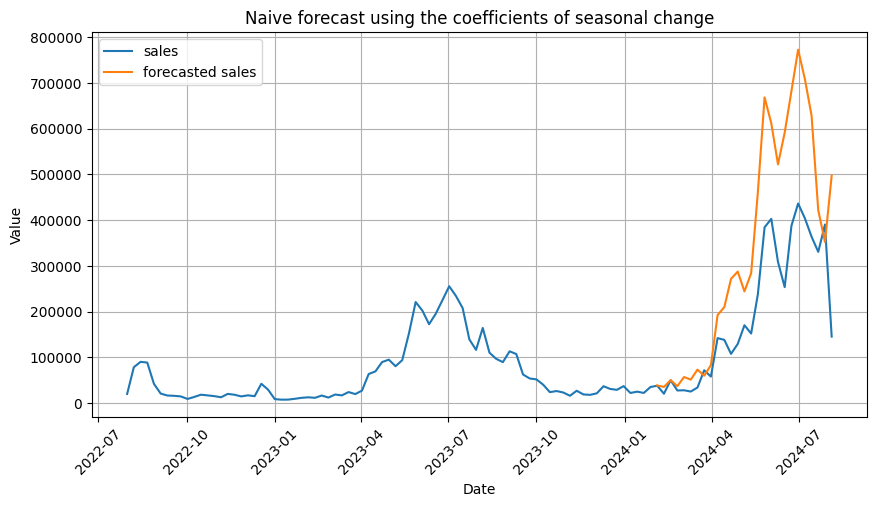

In [ ]:
visualize((weekly_sum['date'], weekly_sum[target_var], target_var),
          (weekly_sum.loc[train_size:, 'date'], naive_forecast, f'forecasted {target_var}'),
          title='Naive forecast using the coefficients of seasonal change', method=plt.plot)

## SARIMA

In [ ]:
import statsmodels.api as sm

### Preparing the dataset

In [ ]:
dataset = weekly_sum.copy()

In [ ]:
dataset.drop(
    columns=[col for col in ['sales', 'total_sales'] if col != target_var],
    inplace=True
)

In [ ]:
train = dataset.loc[:train_size - 1, :]
test = dataset.loc[train_size:, :]

### Training the model

In [ ]:
model = sm.tsa.statespace.SARIMAX(np.log(train[target_var]), order=(1, 1, 1),
                                  seasonal_order=(0, 1, 0, 52)).fit(disp=True)

In [ ]:
sarima_forecast = np.exp(model.predict(start=train.shape[0], end=dataset.shape[0] - 1))

### Plotting the results

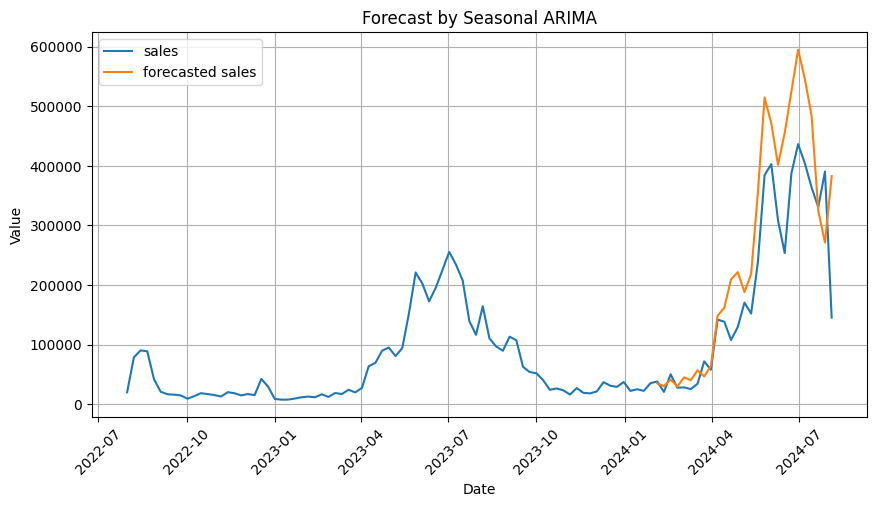

In [ ]:
visualize((dataset['date'], dataset[target_var], target_var),
          (dataset.loc[train_size:, 'date'], sarima_forecast, f'forecasted {target_var}'),
          title='Forecast by Seasonal ARIMA')

## Facebook Prophet

In [ ]:
from prophet import Prophet
from mango import Tuner
from scipy.stats import uniform
import holidays

In [ ]:
import logging

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

### Preparing the dataset

In [ ]:
dataset = weekly_sum.copy()

In [ ]:
dataset.drop(
    columns=[col for col in ['sales', 'total_sales'] if col != target_var],
    inplace=True
)

In [ ]:
# renaming the 'date' and 'total_sales' columns for the back-end of
# FB Prophet to run
dataset.rename(columns={'date': 'ds', target_var: 'y'}, inplace=True)

In [ ]:
holidays_df = pd.DataFrame(
    {
        'holiday': 'financial_holiday',
        'ds': [pd.to_datetime(date) for date in holidays.financial_holidays('RU', years=[2023, 2024])]
    }
)

### Training the model

In [ ]:
train = dataset.loc[:train_size - 1, :]
test = dataset.loc[train_size:, :]

In [ ]:
param_space = dict(
    seasonality_prior_scale=uniform(.01, 10), changepoint_prior_scale=uniform(.001, .5),
    holidays_prior_scale=uniform(.01, 10), seasonality_mode=['additive', 'multiplicative'],
    yearly_seasonality=[False, True]
)

In [ ]:
def summary(args):
    global train, test, holidays_df

    params_evaluated = []
    results = []

    for params in args:
        model = Prophet(growth='linear', holidays=holidays_df, **params)

        model.fit(train)
        forecast = model.predict(test)
        error = mape(test['y'], forecast['yhat'])

        params_evaluated.append(params)
        results.append(error)

    return params_evaluated, results

In [ ]:
tuner = Tuner(param_space, summary, {'initial_random': 10, 'num_iteration': 100})
results = tuner.minimize()

Best score: 0.24544494192673416: 100%|███████████████████████████████████████████████| 100/100 [06:13<00:00,  3.73s/it]


In [ ]:
model = Prophet(growth='linear', holidays=holidays_df, **results['best_params'])

In [ ]:
model.fit(train)
prophet_forecast = model.predict(test)

### Plotting the results

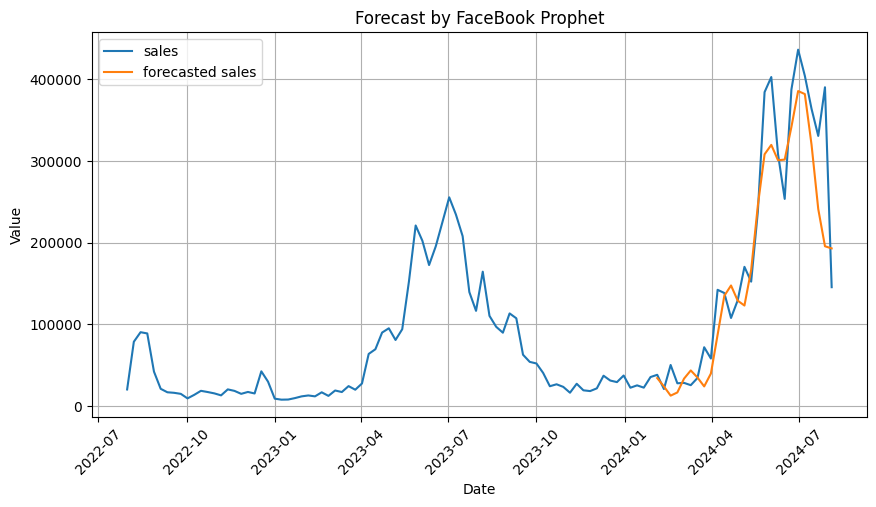

In [ ]:
visualize((dataset['ds'], dataset['y'], target_var),
          (prophet_forecast['ds'], prophet_forecast['yhat'], f'forecasted {target_var}'),
          title='Forecast by FaceBook Prophet')

# Model comparison

In [ ]:
comparison_df = pd.DataFrame(
    {
        'Metric': ['Root MSE', 'MAE', 'MAPE'],

        'Naive': [
            np.sqrt(mse(weekly_sum.loc[train_size:, target_var], naive_forecast)),
            mae(weekly_sum.loc[train_size:, target_var], naive_forecast),
            100 * mape(weekly_sum.loc[train_size:, target_var], naive_forecast)
        ],

        'SARIMA': [
            np.sqrt(mse(weekly_sum.loc[train_size:, target_var], sarima_forecast)),
            mae(weekly_sum.loc[train_size:, target_var], sarima_forecast),
            100 * mape(weekly_sum.loc[train_size:, target_var], sarima_forecast)
        ],

        'FB Prophet': [
            np.sqrt(mse(weekly_sum.loc[train_size:, target_var], prophet_forecast.yhat)),
            mae(weekly_sum.loc[train_size:, target_var], prophet_forecast.yhat),
            100 * mape(weekly_sum.loc[train_size:, target_var], prophet_forecast.yhat)
        ]
    }
)

In [ ]:
comparison_df = comparison_df.map(lambda x: f'{x:.3f}' if not isinstance(x, str) else x).set_index('Metric')

In [ ]:
comparison_df

,Naive,SARIMA,FB Prophet
Metric,,,
Root MSE,184268.493,98114.563,55158.167
MAE,139074.923,72166.887,37942.674
MAPE,73.328,40.580,24.544
